# Pré-processamento

In [4]:
import sys 
!{sys.executable} -m pip install nltk 
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install seaborn
!{sys.executable} -m pip install sklearn

You should consider upgrading via the '/home/celesde/.virtualenvs/products-engine-env/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/celesde/.virtualenvs/products-engine-env/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/celesde/.virtualenvs/products-engine-env/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/celesde/.virtualenvs/products-engine-env/bin/python -m pip install --upgrade pip' command.


In [53]:
from marvin_python_toolbox.common.data import MarvinData
import pandas as pd
import nltk

products_data = pd.read_csv(MarvinData.download_file("https://s3.amazonaws.com/automl-example/produtos.csv"), delimiter=';', encoding='utf-8')
print(products_data.groupby('categoria').size())

# concatenando as colunas nome e descricao
products_data['informacao'] = products_data['nome'] + products_data['descricao']
# excluindo linhas com valor de informacao ou categoria NaN
products_data.dropna(subset=['informacao', 'categoria'], inplace=True)
products_data.drop(columns=['nome', 'descricao'], inplace=True)

categoria
brinquedo    1020
game         1020
livro        1020
maquiagem    1020
dtype: int64


### 29% do dataframe foi removido, porém não é possível utilizar detalhes sem classificação ou classificação sem detalhes. 

In [54]:
print(products_data.groupby('categoria').size())

categoria
brinquedo    668
game         622
livro        838
maquiagem    788
dtype: int64


# Visualização dos dados após exclusão de nulos
não está 100% balanceado e pode ser melhorado posteriormente.

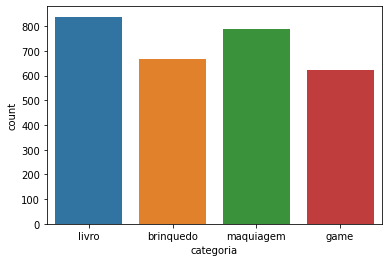

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.countplot(x=products_data['categoria']) 
plt.show() # plota o gráfico por categoria

## Fazendo separação das palavras, removendo pontuação e stopwords

In [56]:
from nltk.corpus import stopwords
stop_words=set(stopwords.words("portuguese"))

# transforma a string em caixa baixa e remove stopwords
products_data['sem_stopwords'] = products_data['informacao'].str.lower().apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
print(products_data['sem_stopwords'].head())

tokenizer = nltk.RegexpTokenizer(r"\w+")
products_data['tokens'] = products_data['sem_stopwords'].apply(tokenizer.tokenize) # aplica o regex tokenizer
products_data.drop(columns=['sem_stopwords','informacao'],inplace=True) # Exclui as colunas antigas

products_data["strings"]= products_data["tokens"].str.join(" ") # reunindo cada elemento da lista
products_data.head()
marvin_initial_dataset = products_data

0    hobbit - 7ª ed. 2013 produto novobilbo bolseir...
1    livro - it coisa - stephen king produto novodu...
2    box crônicas gelo fogo pocket 5 livros produto...
3    box harry potter produto novo físico série har...
4    livro origem - dan brown produto novode onde v...
Name: sem_stopwords, dtype: object


In [57]:
from nltk.probability import FreqDist
fdist = products_data['tokens'].apply(FreqDist) # calcula a frequência de cada token
print(fdist.head()) # frequencia na coluna sem stop_words

0    {'hobbit': 2, '7ª': 1, 'ed': 1, '2013': 2, 'pr...
1    {'livro': 1, 'it': 2, 'coisa': 5, 'stephen': 2...
2    {'box': 2, 'crônicas': 3, 'gelo': 3, 'fogo': 3...
3    {'box': 2, 'harry': 26, 'potter': 21, 'produto...
4    {'livro': 1, 'origem': 2, 'dan': 1, 'brown': 2...
Name: tokens, dtype: object


In [58]:
products_data.head()

,categoria,tokens,strings
0,livro,"[hobbit, 7ª, ed, 2013, produto, novobilbo, bol...",hobbit 7ª ed 2013 produto novobilbo bolseiro h...
1,livro,"[livro, it, coisa, stephen, king, produto, nov...",livro it coisa stephen king produto novodurant...
2,livro,"[box, crônicas, gelo, fogo, pocket, 5, livros,...",box crônicas gelo fogo pocket 5 livros produto...
3,livro,"[box, harry, potter, produto, novo, físico, sé...",box harry potter produto novo físico série har...
4,livro,"[livro, origem, dan, brown, produto, novode, o...",livro origem dan brown produto novode onde vie...


# Separando os dados em treino e teste
80% para treino e 20% para teste

In [59]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split( # Separação dos dados para teste e treino
    marvin_initial_dataset["strings"], 
    marvin_initial_dataset["categoria"], 
    test_size = 0.2, 
    random_state = 10
)
# CountVectorizer
vect = CountVectorizer()
vect.fit(marvin_initial_dataset["strings"])

marvin_dataset = { 
    "X_train": vect.transform(X_train),
    "X_test": vect.transform(X_test),
    "y_train": y_train,
    "y_test" : y_test,
    "vect": vect
}



In [60]:
# TfidfVectorizer
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)

## Treino

In [61]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(marvin_dataset["X_train"], marvin_dataset["y_train"])

marvin_model = {
    "clf" : clf,
    "vect": marvin_dataset["vect"]
}


# Rede neural Perceptron Multicamadas
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(70, ), random_state=1, verbose=True)
mlp.fit(X_train_tfidf, y_train) # Treino do classificador

# Metricas

In [63]:
from sklearn.metrics import accuracy_score
from sklearn import metrics
# Multinomial NB
y_prediction = marvin_model["clf"].predict(marvin_dataset["X_test"])
accuracy = accuracy_score(y_prediction, marvin_dataset["y_test"])

print ("Precisão do multinomialNB: ")
print (accuracy)

marvin_metrics = accuracy 

Precisão do multinomialNB: 
0.9811643835616438



# MPL Classifier
vect_transform = vectorizer.transform(X_test)
predicted = mlp.predict(vect_transform)

print ("\nPrecisão da Rede Neural: ")
#print(metrics.classification_report(y_test, predicted,target_names=y_test.unique()))

y_prediction = mlp.predict(vect_transform)
accuracy = accuracy_score(y_prediction, marvin_dataset["y_test"])
print (accuracy)

#marvin_metrics = accuracy 

# Preparaçao para prediçao

In [67]:
input_message = ["Child of Light Ubisoft Connect Key GLOBAL"]
input_message = marvin_model["vect"].transform(input_message)

# Prediçao final

In [68]:
final_prediction = marvin_model["clf"].predict(input_message)[0]
print("Predicted value: " + final_prediction)

Predicted value: game
